## Import Packages

In [1]:
# Import packages
%matplotlib inline

from surprise import Reader
from surprise import SVD,SVDpp, NMF, NormalPredictor
from surprise import KNNBasic
from surprise import Dataset
from surprise import Trainset
from surprise import accuracy
from surprise.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from itertools import combinations
from collections import defaultdict
import random
import copy
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
#Install recmetrics directly from Github repo
#in terminal by using: pip install git+https://github.com/statisticianinstilettos/recmetrics.git
import recmetrics

In [3]:
np.random.seed(0)
random.seed(0)
warnings.filterwarnings('ignore')

In [4]:
#Time the performance of our cell blocks. 
%load_ext autotime

time: 443 µs (started: 2021-08-04 18:41:33 -06:00)


##  Load small dataset for model selection and hyperparam tuning. 

In [5]:
def filter_ratings(df, min_ratings):
    
    '''Filter users with num_ratings below min_ratings
    params: df, min_ratings
    return: sorted_filtered_df
    '''
    
    # Value counts of user ratings
    user_ratings_counts = df['userId'].value_counts()
    # List of users with ratings counts greater than min_ratings
    filtered_users = user_ratings_counts[user_ratings_counts >= min_ratings].index
    # Filter df to list of users above
    filtered_df = df[df['userId'].isin(filtered_users)]
    
    return filtered_df

time: 430 µs (started: 2021-08-04 18:41:33 -06:00)


In [6]:
def train_dev_test_split(ratings_df, dev_size=1, test_size=1):
    
    '''
    Split user ratings data into train, development and test sets holding the last 
    [test_size] ratings per user for test and last [dev_size] ratings per user for 
    development, following reverse chronological order
    
    Parameters
    ----------
    ratings_df : A dataframe of ratings data
    dev_size : The number of ratings per user to set asside development data
    test_size : The number of ratings per user to set asside test data
    
    Returns
    -------
    train_df : Dataframe of training ratings data
    dev_df : Dataframe of development ratings data
    test_df :  Dataframe of test ratings data
    '''
    
    # Add a column that ranks each rating in reverse chronolgical grouped by user
    ratings_df['rank'] = ratings_df.groupby(['userId'])['timestamp'] \
                         .rank(method='first', ascending=False).copy()
    
    # Filter to test data using rank column
    test_df = ratings_df[ratings_df['rank'].isin(range(1,1+test_size))][['userId', 'movieId', 'rating']]
    
    # Filter to dev data using rank column
    dev_df = ratings_df[ratings_df['rank'].isin(range(1+test_size, 1+test_size+dev_size))][['userId', 'movieId', 'rating']]
    
    # Filter to train data using rank column
    train_df = ratings_df[ratings_df['rank'] >= (1+test_size+dev_size)][['userId', 'movieId', 'rating']]
        
    return train_df, dev_df, test_df

time: 689 µs (started: 2021-08-04 18:41:33 -06:00)


In [7]:
def create_evaluation_pools(train_df, test_df, pool_size=100):
    
    '''
    Create pools of movies to evaluate the collaborative filtering models.
    Each pool will contain pool_size movies per user. Each pool includes the 
    movies in the test_df and randomly selects the rest of the movies from 
    those not watched by the user.
    
    Parameters
    ----------
    train_df : A dataframe of the training ratings data
    test_df : A dataframe of the test ratings data
    pool_size : The size of each movie pool
    
    Returns
    -------
    evaluation_pools_dict : A dictionary from user to the pool of movies on 
                            which to evaluate the recommender system
    
    '''
    
    # Find the list of unique users and movies in the training data
    users = set(train_df['userId'].unique())
    movies = set(train_df['movieId'].unique())
    
    # Instantiate the output dictionary
    evaluation_pools_dict = {}
    
    # Loop through each user
    for user in users:
        
        # Find set of movies rated by the user in the training and test data
        train_movies = set(train_df[train_df['userId']==user]['movieId'])
        test_movies = set(test_df[test_df['userId']==user]['movieId'])
        
        # Find the set of movies not rated by the user
        movies_not_rated = movies - train_movies - test_movies
        
        # Randomly sample movies from the movies not rated by the user
        n_movies_to_choose = pool_size - len(test_movies)
        sample_movies_not_rated = set(random.sample(movies_not_rated, n_movies_to_choose))
        
        # Combine the test movies with the random sample of movies
        evaluation_pool = list(test_movies | sample_movies_not_rated)
        
        # Add each evaluation_pool to the output dictionary 
        evaluation_pools_dict[user] = evaluation_pool
    
    return evaluation_pools_dict

time: 693 µs (started: 2021-08-04 18:41:33 -06:00)


In [8]:
#Load data into ratings_df. 
ratings_df_small = pd.read_csv("/Users/jericojohns/Desktop/W207/data/ratings_small.csv", low_memory=False)

time: 50 ms (started: 2021-08-04 18:41:33 -06:00)


In [9]:
#Filter our user list to those users who have 30+ ratings
filtered_data_small = filter_ratings(ratings_df_small, min_ratings = 30)

#Now split our data so that we take the n-1 (most recent) rating as our test rating, 
#and n-2 (second most recent) rating as our dev rating 
train_df_small, dev_df_small, test_df_small = train_dev_test_split(filtered_data_small)

dev_evaluation_pools_small = create_evaluation_pools(train_df_small, dev_df_small)
test_evaluation_pools_small = create_evaluation_pools(train_df_small, test_df_small)

#Create a surprise Reader object to help us create a Surprise DataSet object. 
reader = Reader()

#Now we load training data as is (no folding) by calling the .build_full_trainset() method. 
train_data_small = Dataset.load_from_df(train_df_small, reader).build_full_trainset()


#Convert dev_data to DataSet object, and then as testset object by calling .buildtestset()
dev_data_small = Dataset.load_from_df(dev_df_small, reader).build_full_trainset()
dev_data_small = dev_data_small.build_testset()

#Convert test_data to DataSet object, and then as testset object by calling .buildtestset()
test_data_small = Dataset.load_from_df(test_df_small, reader).build_full_trainset()
test_data_small = test_data_small.build_testset()

time: 1.47 s (started: 2021-08-04 18:41:33 -06:00)


In [10]:
# Inspect train_df_small
train_df_small.shape

(96158, 3)

time: 2.51 ms (started: 2021-08-04 18:41:35 -06:00)


## Import Prepocessed, Full Dataset. 

In [11]:
path_clean_data = '/Users/jericojohns/Desktop//W207/W207_movies/data/clean_data/'

time: 256 µs (started: 2021-08-04 18:41:35 -06:00)


In [12]:
# Load train, dev, test data
train_df = pd.read_csv(path_clean_data + "cf_train_ratings.csv", low_memory=False)
dev_df = pd.read_csv(path_clean_data + "cf_dev_ratings.csv", low_memory=False)
test_df = pd.read_csv(path_clean_data + "cf_test_ratings.csv", low_memory=False)

time: 6.65 s (started: 2021-08-04 18:41:35 -06:00)


In [13]:
# drop 'Unnamed 0' column
train_df.drop('Unnamed: 0', axis=1, inplace=True)
dev_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)

time: 284 ms (started: 2021-08-04 18:41:41 -06:00)


In [14]:
# Inspect train_df
train_df.head()

,userId,movieId,rating
0,4,223,4.0
1,4,415,4.0
2,4,648,4.0
3,4,1097,5.0
4,4,1197,4.0


time: 9.7 ms (started: 2021-08-04 18:41:42 -06:00)


In [15]:
#Load dev and test evaluation pools
f1 = open(path_clean_data + 'dev_evaluation_pools.json',)
f2 = open(path_clean_data + 'test_evaluation_pools.json',)
dev_evaluation_pools = json.load(f1)
test_evaluation_pools = json.load(f2)

# Convert key from str to int
dev_evaluation_pools = {int(k):v for k,v in dev_evaluation_pools.items()}
test_evaluation_pools = {int(k):v for k,v in test_evaluation_pools.items()}

time: 4.7 s (started: 2021-08-04 18:41:42 -06:00)


In [16]:
#Create empty global lists to append our results
algo_list = [] 
hr_list = []
hr_cutoff_list = [] 
avg_est_rating_list = []
avg_novelty_list = []
rmse_list = []

time: 453 µs (started: 2021-08-04 18:41:46 -06:00)


#### Add views on full dataset. 

<AxesSubplot:title={'center':'Distribution of Movie Ratings'}>

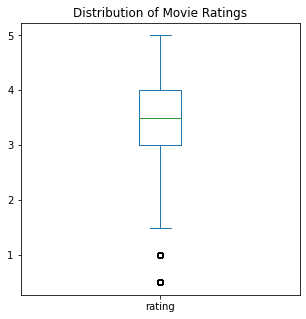

time: 2.49 s (started: 2021-08-04 21:34:12 -06:00)


In [98]:
#Boxplot of ratings of train_data
train_df[['rating']].plot.box(title = 'Distribution of Movie Ratings', figsize = (5,5))

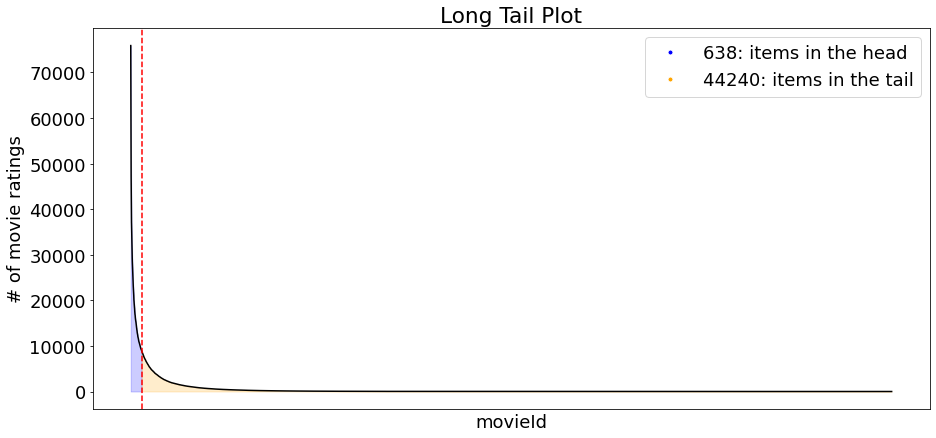

time: 1min 1s (started: 2021-08-04 21:34:19 -06:00)


In [99]:
#Use recmetrics for Long Tail Plot Example of MovieID
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=train_df, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

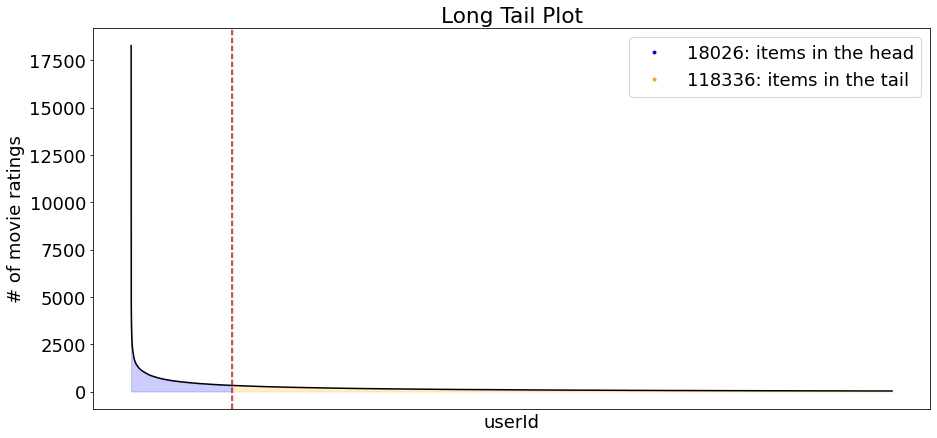

time: 4min 9s (started: 2021-08-04 21:35:21 -06:00)


In [100]:
#Use recmetrics for Long Tail Plot Example of MovieID
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=train_df, 
             item_id_column="userId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

## Load Data into Surprise Data Structures

In [20]:
#Create a surprise Reader object to help us create a Surprise DataSet object. 
reader = Reader()

#Now we load training data as is (no folding) by calling the .build_full_trainset() method. 
train_data = Dataset.load_from_df(train_df, reader).build_full_trainset()

#Convert dev_data to DataSet object, and then as testset object by calling .buildtestset()
dev_data = Dataset.load_from_df(dev_df, reader).build_full_trainset()
dev_data = dev_data.build_testset()

#Convert test_data to DataSet object, and then as testset object by calling .buildtestset()
test_data = Dataset.load_from_df(test_df, reader).build_full_trainset()
test_data = test_data.build_testset()

time: 37.2 s (started: 2021-08-04 18:41:46 -06:00)


## Run and Evaluate Matrix Factorization Models

### Define Custom Functions

In [77]:
def calculateItemNovelty(ratings_df):
    '''Create two lists of 1.) sc_rankings (standardized and minMaxScaled)
    and 2.) movieIDs that correspond to those rankings.'''
    rankings = ratings_df["movieId"].value_counts()
    ratings =  ratings_df[['movieId','rating']].groupby('movieId').mean()

    #Let's standardize our rankings to be able to be used together 
    scaler = MinMaxScaler(feature_range = (0,5))
    scaler2 = RobustScaler()
    ranking_movieID = rankings.index.to_numpy()
    ratings = ratings.to_numpy().reshape(-1,1)
    
    #Now fit the robustscaler to our ratings. 
    scaler2.fit(ratings)
    sc_rankings = rankings.to_numpy().reshape(-1,1)
    
    #Robust scaler transforms novelty data based on distribution of rating data (this is important for our blended novelty swapping). 
    sc_rankings = scaler2.transform(sc_rankings)
    
    #Fit and transform the standardized rankings to 0,5 scale. 
    sc_rankings = scaler.fit_transform(sc_rankings)


    sc_rankings = sc_rankings.tolist()
    
    #Now flip the ratings to negative and add 5 so that the most popular movies have low novelty score. 
    sc_rankings = [(float(i[0])*-1)+5 for i in sc_rankings]


    ranking_movieID = ranking_movieID.tolist()
    ranking_movieID = {k: v for v, k in enumerate(ranking_movieID)}
    return sc_rankings, ranking_movieID

time: 689 µs (started: 2021-08-04 21:12:13 -06:00)


In [22]:
def sort_evaluation_pools(model, evaluation_pools, ranking_list, ranking_movies):
    '''
    Take evaluation pool for each user and sort it based on ratings predicted by a 
    trained model in descending order of predicted ratings
    Parameters
    ----------
    model : A trained surprise model
    evaluation_pools : A dictionary from user to the pool of movies on 
                       which to evaluate the recommender system 
    ranking_list = movie novelty scores
    ranking_movies = movieIDs tied to novelty scores
    
    Returns
    -------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    '''
    
    # Instantiate output dictionary
    sorted_evaluation_pools = {}
    
    # Loop through each key-value pair in the input dictionary
    for user, movie_pool in evaluation_pools.items():
        # Create a dictionary for the predicted rating of each movie in the user's pool
        predictions = {}
        for movie in movie_pool:
            pred = model.predict(user, movie)
            try: 
                novelty = ranking_list[ranking_movies[movie]]
            except: 
                novelty = 5
            predictions[movie] = (pred[3],novelty)
            #Add in the novelty score
            
        
        # Sort the pool in descending order of predicted ratings
        sorted_pool = [(k,v) for k, v in sorted(predictions.items(), key=lambda item: item[1], reverse=True)]
        
        # Add key-value pair of user and sorted evalualtion pool to the output dictionary
        sorted_evaluation_pools[user] = sorted_pool
        
    #Finally reformat our dictionary to be in format userID: (movieID, rating, novelty)
    final_pool = defaultdict(list)
    for userID in sorted_evaluation_pools: 
        for movieID, tup in sorted_evaluation_pools[userID]: 
            final_pool[int(userID)].append((int(movieID), tup[0], tup[1]))


    return final_pool

time: 743 µs (started: 2021-08-04 18:42:24 -06:00)


In [23]:
def calc_hit_rate_pools(sorted_evaluation_pools, test_df, top_n=10):
    '''
    Calculate hit rate given a dictionary of sorted evaluation pools and the corrsponding 
    test data frame. A hit is defined as finding a test movie in the top_n of sorted 
    evalutation pool of a user
    Parameters
    ----------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    test_df : A dataframe of ratings for movies being tested in the evaluation pools
    top_n : The threshold above which a test movies should be found to be called a hit
    
    Returns
    -------
    hit_rate : A hit rate across pools
    
    '''
    
    # Start with hits and totals at 0
    hits=0
    total=0
    
    # Loop through the each key-value pair in the input dictionary
    for user, sorted_pool in sorted_evaluation_pools.items():
        
        # Filter to test movies for the user
        test_movies = test_df[test_df['userId']==user]
        
        # Find top_n movies from the pool
        top_movies = sorted_pool[:top_n]
        
        # Loop through each test movie
        for index, test_movie in test_movies.iterrows():
            test_movie_id = test_movie['movieId']
            
            # If test movie is in top_movies, then add one to hits
            for movie, rating, novelty in top_movies: 
                if test_movie_id == movie:
                    hits += 1
                
            # Add one to total for each test movie  
            total += 1
     
    hit_rate = hits/total
    return hit_rate

time: 833 µs (started: 2021-08-04 18:42:24 -06:00)


In [24]:
def calc_hit_rate_pools_with_cutoff(sorted_evaluation_pools, test_df, top_n=10, rating_cutoff=0):
    '''
    Calculate hit rate given a dictionary of sorted evaluation pools and a corresponding 
    test data frame. A hit is defined as finding a test movie that has a rating greater 
    than a rating_cutoff in the top_n of sorted evalutation pool of a user.
    Parameters
    ----------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    test_df : A dataframe of ratings for movies being tested in the evaluation pools
    top_n : The threshold above which a test movies should be found to be called a hit
    rating_cutoff : The threshold rating above which a test movie should be evaluated
    
    Returns
    -------
    hit_rate : A hit rate across pools
    '''
    
    # Start with hits and totals at 0
    hits=0
    total=0
    
    # Loop through the each key-value pair in the input dictionary
    for user, sorted_pool in sorted_evaluation_pools.items():
        
        # Filter to test movies for the user
        test_movies = test_df[test_df['userId']==user]

         # Find top_n movies from the pool
        top_movies = sorted_pool[:top_n]
        
        # Loop through each test movie
        for index, test_movie in test_movies.iterrows():
            test_movie_rating = test_movie['rating']
            test_movie_id = test_movie['movieId']
            
             # If test movie has a rating above rating_cutoff then evaluate
            if test_movie_rating >= rating_cutoff:
                
                # If test movie is in top_movies, then add one to hits
                # If test movie is in top_movies, then add one to hits
                for movie, rating, novelty in top_movies: 
                    if test_movie_id == movie:
                        hits += 1
                
                # Add one to total for each test movie
                total += 1

    return hits/total

time: 586 µs (started: 2021-08-04 18:42:24 -06:00)


In [25]:
def summaryStats(sorted_evaluation_pools, test_df, test_prediction, rating_cutoff = 4): 
    '''Calculate average novelty, average rating, and hit rate for the top 10 of final sorted_evaluation_pool.'''
    hit_rate_pools = calc_hit_rate_pools(sorted_evaluation_pools, test_df)
    hit_rate_pools_with_cutoff =  calc_hit_rate_pools_with_cutoff(sorted_evaluation_pools, test_df, rating_cutoff=rating_cutoff)
    rmse = accuracy.rmse(test_prediction, verbose = False)
    total_est_rating = 0 
    total_novelty = 0 
    total_items = 0 
    for userID in sorted_evaluation_pools.keys(): 
        for tup in sorted_evaluation_pools[userID][:10]: 
            total_est_rating += tup[1]
            total_novelty += tup[2]
            total_items += 1
    
    avg_est_rating  = total_est_rating / total_items
    avg_novelty = total_novelty / total_items
    
    return hit_rate_pools, hit_rate_pools_with_cutoff, avg_est_rating, avg_novelty, rmse 
        


time: 1.15 ms (started: 2021-08-04 18:42:24 -06:00)


In [26]:
def compareModels(models, train_data, dev_data, dev_df, dev_evaluation_pools, hyperparams = False): 
    '''For baseline model selection of matrix factorization models.
    Choose model that optimizes hit_rate_pools_with_cutoff.'''
    
    for algo in models: 
        #Print model type 
        print(type(algo).__name__)
        
        #Train our train_data (all user's that have liked 30+ movies, train on the n-2 movie set)
        algo.fit(train_data)
        dev_prediction = algo.test(dev_data)
        
        #Sort our evaluation pool, using the algo. 
        sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools, sc_rankings, ranking_movieID) 
        
        #Calculate summary stats for each model. 
        hit_rate_pools, hit_rate_pools_with_cutoff, avg_est_rating, avg_novelty, rmse = summaryStats(sorted_dev_evaluation_pools, dev_df, dev_prediction, rating_cutoff = 4)
        print(f'HR@10: {hit_rate_pools}')
        print(f'HR@10 w/ Cutoff: {hit_rate_pools_with_cutoff}')
        print(f'RMSE: {rmse}')
        print(f'AvgRating@10: {avg_est_rating}')
        print(f'AvgNovelty@10: {avg_novelty}')
        #Since SVD and SVD with optimal params will return SVD, we need to specify the tuned model. 
        if hyperparams == False: 
            algo_list.append(type(algo).__name__)
        else: 
            algo_list.append('SVD w/ Hyperparam Tuning')
        #Append summary stats to our global lists so that we can plot. 
        hr_list.append(hit_rate_pools)
        hr_cutoff_list.append(hit_rate_pools_with_cutoff)
        avg_est_rating_list.append(avg_est_rating)
        avg_novelty_list.append(avg_novelty)
        rmse_list.append(rmse)
        

time: 1.84 ms (started: 2021-08-04 18:42:24 -06:00)


In [27]:
def bestHyperparams(n_factors, n_epochs, lr_all, reg_all): 
    '''Non-exhaustive (manual) search over hyperparam values to
    select the best hyperparam values for hit_rate_pools_with_cutoff.'''
    
    #Initialize all optimal paramst to 0. 
    best_hr = 0
    best_n_factors = 0
    best_n_epochs = 0 
    best_lr_all = 0 
    best_reg_all = 0
    
    #Iterate through all (note this is a non-exhaustive list) param combinations. 
    for n_factor in n_factors: 
        for n_epoch in n_epochs: 
            for lr in lr_all: 
                for reg in reg_all: 
                    algo = SVD(n_factors = n_factor, n_epochs = n_epoch, lr_all = lr, reg_all = reg)
                    algo.fit(train_data_small)
                    sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools_small, sc_rankings, ranking_movieID)
        

                    #Calculate the two hit rates
                    hit_rate_pools = calc_hit_rate_pools(sorted_dev_evaluation_pools, dev_df_small)
                    hit_rate_pools_with_cutoff = calc_hit_rate_pools_with_cutoff(sorted_dev_evaluation_pools, dev_df_small, rating_cutoff=4)
                    
                    #If HR@10 with Cutoff is higher, save the params as the optimal params. 
                    if hit_rate_pools_with_cutoff > best_hr: 
                        best_hr = hit_rate_pools_with_cutoff
                        best_n_factors = n_factor
                        best_n_epochs = n_epoch
                        best_lr_all = lr
                        best_reg_all = reg

    #Print summary of our best params. 
    print(f'Best HR@10: {best_hr}')
    print(f'n_factors = {best_n_factors}, n_epochs = {best_n_epochs}, lr_all = {best_lr_all}, reg_all = {best_reg_all}')
    
    #Return all optimal params. 
    return best_n_factors, best_n_epochs, best_lr_all, best_reg_all


time: 1.39 ms (started: 2021-08-04 18:42:24 -06:00)


In [28]:
def GetTopNSplitPools(sorted_evaluation_pool):
    '''Get the top n predicted movie ratings for a given user, 
    the next n, and the rest of the evaluation pool. 
    Used to process sorted_evaluation_pool before 
    diversificationSwap().'''
    predictions = sorted_evaluation_pool
    topN = defaultdict(list)
    nextN = defaultdict(list)
    remainingN = defaultdict(list)
    
    #Select top_n and remaining_n
    for userID, movies in predictions.items():
        topN[int(userID)] = movies[:10]
        #Pull the next n items as the remainingN list 
        nextN[int(userID)] = movies[10:30]
        remainingN[int(userID)] = movies[30:]
        

    return topN, nextN, remainingN

time: 754 µs (started: 2021-08-04 18:42:24 -06:00)


In [29]:
def diversificationSwap(topNPredicted, nextNPredicted, remainingNPredicted, iterations = 1): 
    '''For iteration in desired number of iterations (hyperparam): 
    drop the lowest novelty item from the topN list and
    replace with the highest novelty item from the remainingN list.'''
    
    #Deepcopy our dictionaries since they are mutable. This way we are only changing the new dictionaries
    #and preserve our original inputs. 
    topNPredicted_temp = copy.deepcopy(topNPredicted)
    nextNPredicted_temp = copy.deepcopy(nextNPredicted)
    
    #Specifies the number of swaps we'd like to attempt. 
    for i in range(iterations): 
        for userID in topNPredicted_temp.keys():
            #Create a boolean that indicates whether swap is found
            swap_top = False
            
            #Drop items from topN and add to remainingN
            min_ranking = 5 
            min_movieID = None
            min_rating = None
            
            #Store the proper variables. 
            for item in topNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                
                #Save and update the minimum novelty item. 
                if rank < min_ranking: 
                    swap_top = True
                    min_ranking = rank
                    min_movieID = movieID
                    min_rating = rating
                    
                    
            #Now shuffle (only if swap is found)
            if swap_top == True: 
                nextNPredicted_temp[int(userID)].append((int(min_movieID), min_rating, min_ranking))
                topNPredicted_temp[int(userID)].remove((int(min_movieID), min_rating, min_ranking))
            
            #Create a boolean that indicates whether swap is found
            swap_bottom  = False
            
            #Add items to topN and drop from remainingN
            max_ranking = 0 
            max_movieID = None
            max_rating = None
            
            #Store the proper variables. 
            for item in nextNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                
                #Save and update the maxiumum novelty item. 
                if rank > max_ranking: 
                    swap_bottom = True
                    max_ranking = rank
                    max_movieID = movieID
                    max_rating = rating
                    
            #Now shuffle (only if swap is found)
            if swap_bottom == True: 
                topNPredicted_temp[int(userID)].append((int(max_movieID), max_rating, max_ranking))
                nextNPredicted_temp[int(userID)].remove((int(max_movieID), max_rating, max_ranking))
    
    #Create a combined dictionary for our final pool. 
    final_sorted_pool = defaultdict(list)
    
    #Add the top predicted, diversified items to our final evaluation_pool
    for userID in topNPredicted_temp.keys(): 
        for item in topNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the next N 
    for userID in nextNPredicted_temp.keys(): 
        for item in nextNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the remaining (unswapped) N items to create the full diversified evaluation pool 
    for userID in remainingNPredicted.keys(): 
        for item in remainingNPredicted[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
        
    return final_sorted_pool
        

time: 1.92 ms (started: 2021-08-04 18:42:24 -06:00)


In [30]:
def diversificationSwapBlended(topNPredicted, nextNPredicted, remainingNPredicted, iterations = 1, w1 = 0.5, w2 = 0.5): 
    '''For iteration in desired number of iterations (hyperparam): 
    drop the lowest blended rating and novelty item from the topN list and
    replace with the highest blended rating and novelty item from the remainingN list.
    This methods approximate's a movie's 'Hidden Gem' score (i..e high rating, low ranking)'''
    
    #Deepcopy our dictionaries since they are mutable. This way we are only changing the new dictionaries
    #and preserve our original inputs. 
    topNPredicted_temp = copy.deepcopy(topNPredicted)
    nextNPredicted_temp = copy.deepcopy(nextNPredicted)
    
    #Specifies the number of swaps we'd like to attempt. 
    for i in range(iterations): 
        for userID in topNPredicted_temp.keys():
            #Create a boolean that indicates whether swap is found
            swap_top = False
            
            #Drop items from topN and add to remainingN
            min_blended_rank = 5
            min_movieID = None
            min_rating = None
            #Store the proper variables.
            for item in topNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                #The key difference between the diversificationSwap() method, 
                #we utilize both rating and novelty to create a blended metric
                #for improved performance after swapping. 
                blended_rank = (w1*rating) + (w2*rank)
                #Save and update the minimum novelty + rating item.
                if blended_rank < min_blended_rank: 
                    swap_top = True
                    min_blended_rank = blended_rank
                    min_movieID = movieID
                    min_ranking = rank
                    min_rating = rating
                    
                    
            #Now shuffle (only if swap is found)
            if swap_top == True: 
                nextNPredicted_temp[int(userID)].append((int(min_movieID), min_rating, min_ranking))
                topNPredicted_temp[int(userID)].remove((int(min_movieID), min_rating, min_ranking))
            
            #Create a boolean that indicates whether swap is found
            swap_bottom  = False
            
            #Add items to topN and drop from remainingN
            max_blended_rank = 0 
            max_movieID = None
            max_rating = None
            #Store the proper variables.
            for item in nextNPredicted_temp[userID]:
                movieID = item[0]
                rating = item[1]
                rank = item[2]
                #The key difference between the diversificationSwap() method, 
                #we utilize both rating and novelty to create a blended metric
                #for improved performance after swapping. 
                blended_rank = (w1*rating) + (w2*rank)
                #Save and update the maximum novelty + rating item.
                if blended_rank > max_blended_rank: 
                    swap_bottom = True
                    max_blended_rank = blended_rank
                    max_ranking = rank
                    max_movieID = movieID
                    max_rating = rating
                    
            #Now shuffle (only if swap is found)
            if swap_bottom == True: 
                topNPredicted_temp[int(userID)].append((int(max_movieID), max_rating, max_ranking))
                nextNPredicted_temp[int(userID)].remove((int(max_movieID), max_rating, max_ranking))
    
    #Now drop the ranking as this isn't needed for hit rate calcs. 
    #topNPredicted_temp.update(item[:-1] for item in value[items] for value in topNPredicted_temp.values())
    #remainingNPredicted_temp.update(item[:-1] for item in value[items] for value in remainingNPredicted.values())
    final_sorted_pool = defaultdict(list)
    
    #Add the top predicted, diversified items to our final evaluation_pool
    for userID in topNPredicted_temp.keys(): 
        for item in topNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
            #final_topN[int(userID)].append(int(item[0]))
    
    #Add the next N 
    for userID in nextNPredicted_temp.keys(): 
        for item in nextNPredicted_temp[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
    
    #Add the remaining (unswapped) N items to create the full diversified evaluation pool 
    for userID in remainingNPredicted.keys(): 
        for item in remainingNPredicted[userID]: 
            #To drop tuple value we must first convert to list since tuples are immutable. 
            final_sorted_pool[int(userID)].append((int(item[0]), item[1], item[2]))
        
    return final_sorted_pool

time: 2.28 ms (started: 2021-08-04 18:42:24 -06:00)


In [31]:
def calcDiversityTradeoff(topNPredicted_Split, nextNPredicted_Split,remainingNPredicted_Split, test_df, test_prediction):
    '''Plot our novelty / HR@10 tradeoff by increasing number of iterations of our 
    diversificationSwap.'''
    method = []
    average_novelty = [] 
    hit_rate = [] 

    method_blended = []
    average_novelty_blended = []
    hit_rate_blended = []

    hit_rate_cutoff = []
    hit_rate_cutoff_blended = [] 

    swapping_iterations = []
    swapping_iterations_blended = []
    
    #Pass off our split evaluation pools to diversificationSwaps, with differing numbers of swaps to create trade-off chart. 
    for i in range(0,6): 
        diversified_evaluation_pools = diversificationSwap(topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split, iterations = i)
        diversified_evaluation_pools_blended = diversificationSwapBlended(topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split, iterations = i, w1 = 0.7, w2 = 0.3)
        hit_rate_diversified_pools, hit_rate_diversified_pools_with_cutoff, avg_est_rating, avg_novelty, rmse = summaryStats(diversified_evaluation_pools, test_df, test_prediction, rating_cutoff = 4)
        hit_rate_diversified_pools_blended, hit_rate_diversified_pools_with_cutoff_blended, avg_est_rating_blended, avg_novelty_blended, rmse_blended = summaryStats(diversified_evaluation_pools_blended, test_df, test_prediction, rating_cutoff = 4)
        model = 'Matrix Factorization with SVD()'
        blended_model = 'Matrix Factoriziation with SVD(), blended swapping'
        
        #Append all of our results to use in plotting. 
        method.append(model)
        method_blended.append(model)

        average_novelty.append(avg_novelty)
        average_novelty_blended.append(avg_novelty_blended)

        swapping_iterations.append(i)
        swapping_iterations_blended.append(i)

        hit_rate.append(hit_rate_diversified_pools)
        hit_rate_blended.append(hit_rate_diversified_pools_blended)

        hit_rate_cutoff.append(hit_rate_diversified_pools_with_cutoff)
        hit_rate_cutoff_blended.append(hit_rate_diversified_pools_with_cutoff_blended)

    #Return all key results. 
    return method, average_novelty, hit_rate, rmse, method_blended, average_novelty_blended, hit_rate_blended, rmse_blended, hit_rate_cutoff, hit_rate_cutoff_blended, swapping_iterations, swapping_iterations_blended

time: 831 µs (started: 2021-08-04 18:42:24 -06:00)


### Matrix Factorization Process

#### 1.) Calculate Item Novelty. 
##### We will use this in our sorted_evaluation_pools so that we don't need to pull-in novelty data everytime. 

In [32]:
#Calculate item (movieID) novelty. Store in 2 lists. 
sc_rankings, ranking_movieID = calculateItemNovelty(train_df_small)

time: 26.9 ms (started: 2021-08-04 18:42:24 -06:00)


(array([2.000e+00, 3.000e+00, 6.000e+00, 1.200e+01, 1.900e+01, 3.100e+01,
        8.300e+01, 1.330e+02, 4.450e+02, 8.266e+03]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

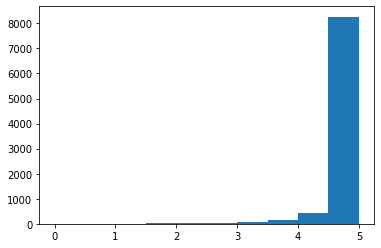

time: 229 ms (started: 2021-08-04 18:42:24 -06:00)


In [33]:
#View distribution
plt.hist(sc_rankings)

#### 2.) Test a baseline SVD() Model. 

In [34]:
# # Train and test algorithm (Matrix Factorization for Collaborative Filtering)
algo = SVD()

# Train our train_data (all user's that have liked 30+ movies, train on the n-2 movie set)
algo.fit(train_data_small)
dev_prediction = algo.test(dev_data_small)

time: 202 µs (started: 2021-08-04 18:42:24 -06:00)


In [35]:
# Sort dev evaluation pools based on SVD model
sorted_dev_evaluation_pools = sort_evaluation_pools(algo, dev_evaluation_pools_small, sc_rankings, ranking_movieID)

#Get summary statistics that we will use across all models. 
hit_rate_pools, hit_rate_pools_with_cutoff, avg_est_rating, avg_novelty, rmse = summaryStats(sorted_dev_evaluation_pools, dev_df_small, dev_prediction, rating_cutoff = 4)

print(f'HR@10: {hit_rate_pools}')
print(f'HR@10 w/ Cutoff: {hit_rate_pools_with_cutoff}')
print(f'AvgRating@10: {avg_est_rating}')
print(f'AvgNovelty@10: {avg_novelty}')
print(f'RMSE: {rmse}')

time: 277 µs (started: 2021-08-04 18:42:24 -06:00)


#### 3.) Compare the three predominant Matrix Factorization Models and a Random Only Predictor. 

In [36]:
#Specify the 3 models
models = [NormalPredictor(), SVD(), SVDpp(), NMF()]
#Compare the 3 models, this will append results to global lists and print results. 
compareModels(models, train_data_small, dev_data_small, dev_df_small, dev_evaluation_pools_small, hyperparams = False)

NormalPredictor
HR@10: 0.10669077757685352
HR@10 w/ Cutoff: 0.09646302250803858
RMSE: 1.5013027242455024
AvgRating@10: 4.965962300580914
AvgNovelty@10: 4.862698219501929
SVD
HR@10: 0.33634719710669075
HR@10 w/ Cutoff: 0.43086816720257237
RMSE: 0.9336144633326652
AvgRating@10: 3.9977336638045387
AvgNovelty@10: 4.519763991282943
SVDpp
HR@10: 0.325497287522604
HR@10 w/ Cutoff: 0.40514469453376206
RMSE: 0.9239364663405027
AvgRating@10: 4.015033550681303
AvgNovelty@10: 4.567229447767367
NMF
HR@10: 0.1518987341772152
HR@10 w/ Cutoff: 0.1864951768488746
RMSE: 0.972349008370244
AvgRating@10: 4.4358329950602675
AvgNovelty@10: 4.797862475077577
time: 11min 5s (started: 2021-08-04 18:42:24 -06:00)


#### 4.) Do a non-exhaustive search for the best baseline model (SVD) hyperarameters. 
##### Note: We use the best params from testing on our small dataset, as running on our large 
##### dataset is too computationally expensive (10+ hours to run). 

In [37]:
#Note default values n_factors = 100, n_epochs = 20, lr_all = 0.005, reg_all = 0.02
n_factors = [50, 100, 200, 500]
n_epochs = [10,20,30]
lr_all = [0.001, 0.005, 0.01]
reg_all = [0, 0.01, 0.02, 0.04]

best_n_factors, best_n_epochs, best_lr_all, best_reg_all = bestHyperparams(n_factors, n_epochs, lr_all, reg_all)

Best HR@10: 0.4983922829581994
n_factors = 50, n_epochs = 30, lr_all = 0.001, reg_all = 0
time: 39min 36s (started: 2021-08-04 18:53:38 -06:00)


#### 5.) Apply our best hyperparams to our best baseline model. 

In [38]:
#Build the best baseline model with the best hyperparams from our small dataset to compare with the full suite of models. 
model = [SVD(n_factors = best_n_factors, n_epochs = best_n_epochs, lr_all = best_lr_all, reg_all = best_reg_all)]

#Compare Model. This will append results to our global lists. 
compareModels(model, train_data_small, dev_data_small, dev_df_small, dev_evaluation_pools_small, hyperparams = True)


SVD
HR@10: 0.379746835443038
HR@10 w/ Cutoff: 0.4758842443729904
RMSE: 0.9733837076819765
AvgRating@10: 3.841709159674724
AvgNovelty@10: 4.420068855195412
time: 4.67 s (started: 2021-08-04 19:33:46 -06:00)


In [39]:
#Manually append Deep Learning Results, from 'model_embedding_depth_1/3/10'
#These are big models that are not able to run within this notebook, hence 
#the manual add. 
dl_models = ['DL Embed:1', 'DL Embed:3', 'DL Embed:10']
dl_hr = [None, None, None]
dl_hr_cutoff = [0.603, 0.709, 0.715]
dl_est_rating = [None, None, None]
dl_novelty = [None, None, None]
dl_rmse = [0.821, 0.769, 0.734]

for i in range(len(dl_models)):
    algo_list.append(dl_models[i])
    hr_list.append(dl_hr[i])
    hr_cutoff_list.append(dl_hr_cutoff[i])
    avg_est_rating_list.append(dl_est_rating[i])
    avg_novelty_list.append(dl_novelty[i])
    rmse_list.append(dl_rmse[i])

time: 670 µs (started: 2021-08-04 19:34:01 -06:00)


#### 5.) Plot baseline model comparison (against HR@10 w/ Cutoff and RMSE)

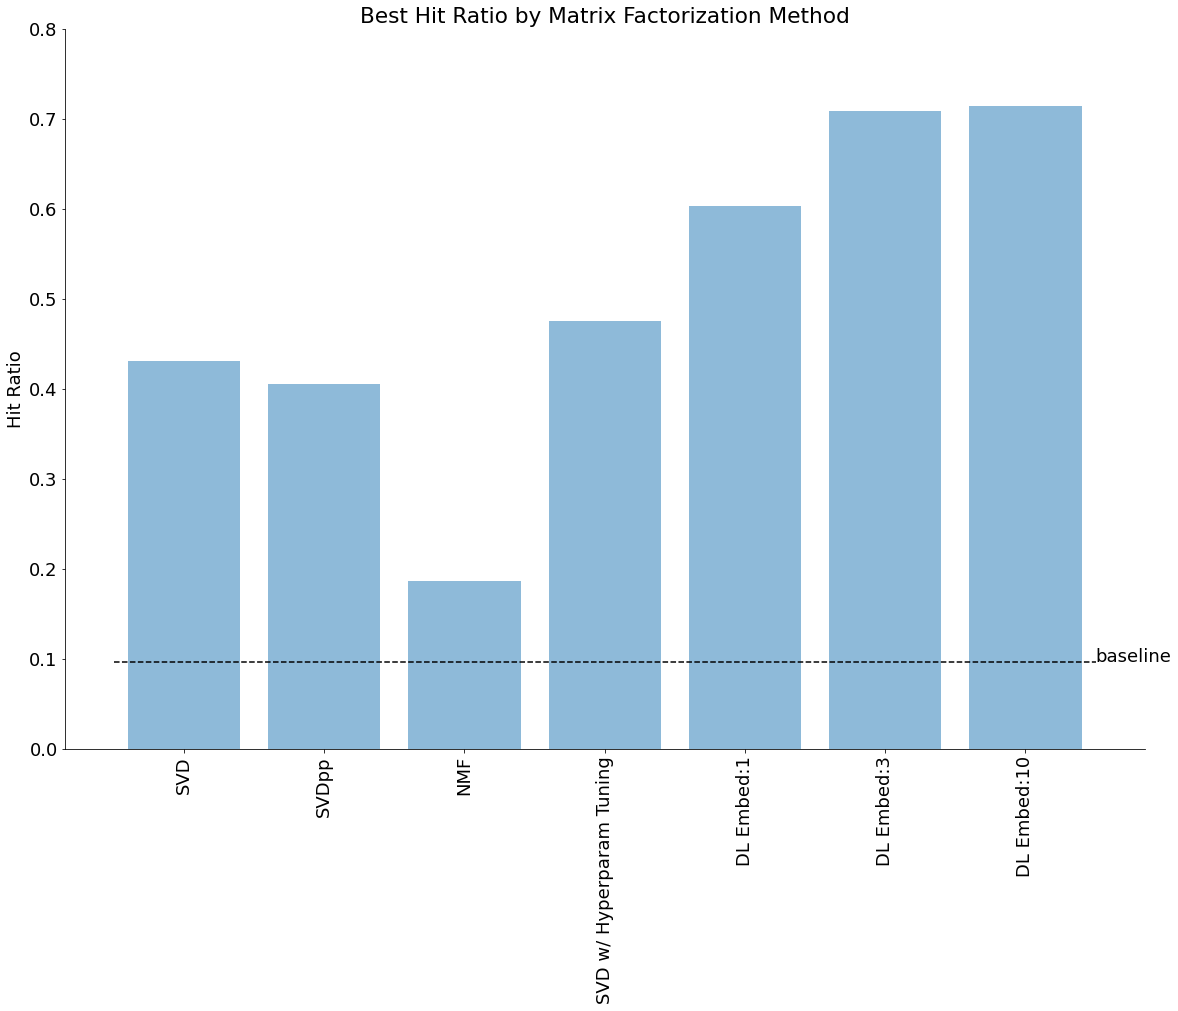

time: 2.84 s (started: 2021-08-04 19:36:54 -06:00)


In [45]:
#Plot HR@10 with Cutoff
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize = (15,10))
ax = fig.add_axes([0,0,1,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(algo_list[1:], hr_cutoff_list[1:], alpha=0.5)
ax.set_xticklabels(algo_list[1:], rotation=90)
ax.hlines(hr_cutoff_list[0], xmin=-0.5, xmax = 6.5, color='black', linestyles='dashed', label='baseline')
ax.text(6.5, hr_cutoff_list[0], 'baseline')
ax.set_ylabel('Hit Ratio')
ax.set_ylim(0.0, 0.8)
ax.set_title('Best Hit Ratio by Matrix Factorization Method')
plt.show()

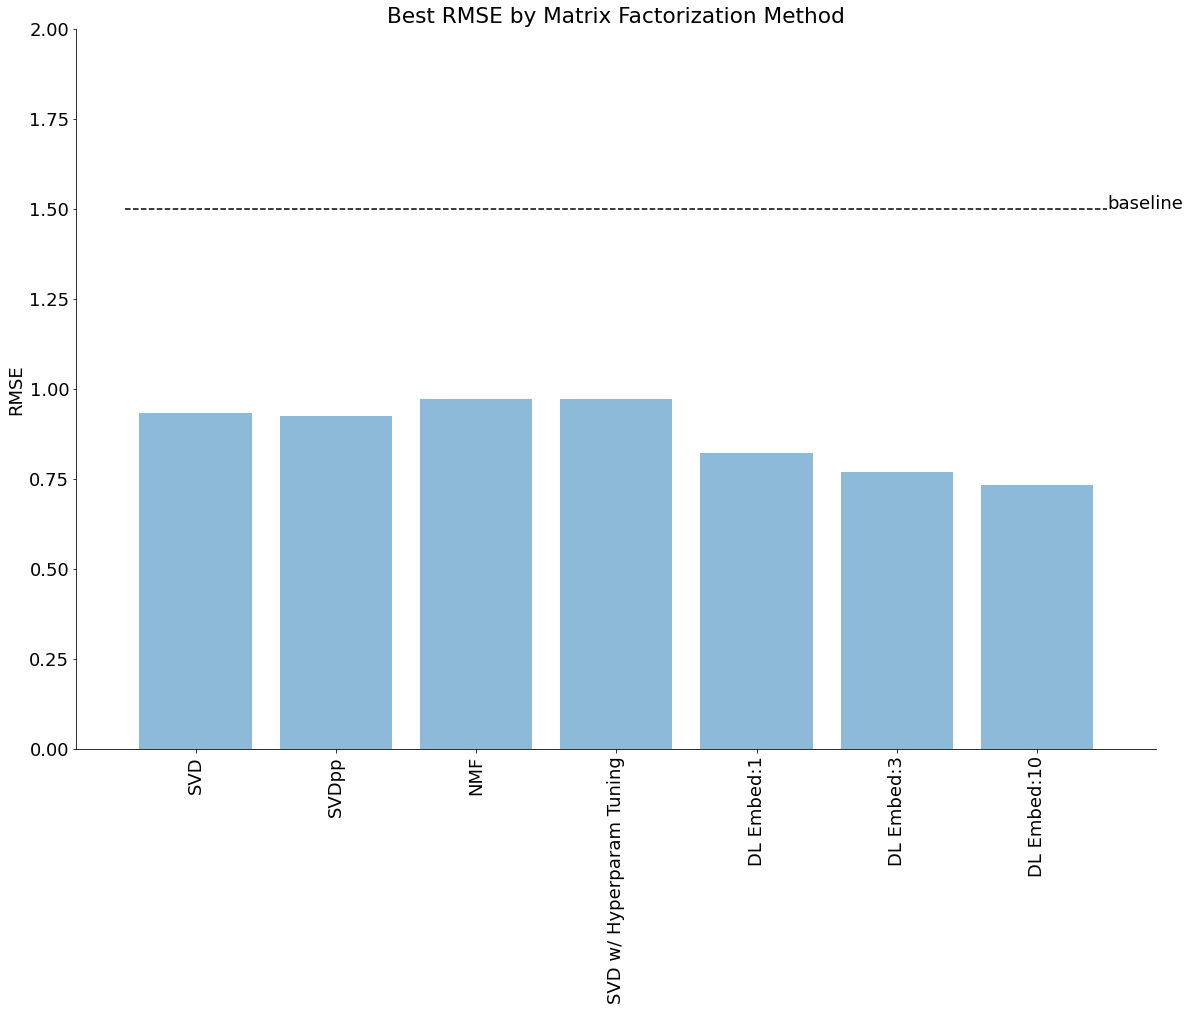

time: 182 ms (started: 2021-08-04 19:38:23 -06:00)


In [46]:
#Plot RMSE
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize = (15,10))
ax = fig.add_axes([0,0,1,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(algo_list[1:], rmse_list[1:], alpha=0.5)
ax.set_xticklabels(algo_list[1:], rotation=90)
ax.hlines(rmse_list[0], xmin=-0.5, xmax=6.5, color='black', linestyles='dashed', label='baseline')
ax.text(6.5, rmse_list[0], 'baseline')
ax.set_ylabel('RMSE')
ax.set_ylim(0.0, 2.0)
ax.set_title('Best RMSE by Matrix Factorization Method')
plt.show()

#### 6.) Switch to test data. 

In [78]:
#Update our novelty list with the full training data. 
#Calculate item (movieID) novelty. Store in 2 lists. 
sc_rankings, ranking_movieID = calculateItemNovelty(train_df)

time: 1.13 s (started: 2021-08-04 21:12:19 -06:00)


(array([4.0000e+00, 3.0000e+00, 5.0000e+00, 1.6000e+01, 1.3000e+01,
        4.0000e+01, 7.4000e+01, 1.5300e+02, 4.7100e+02, 4.4099e+04]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

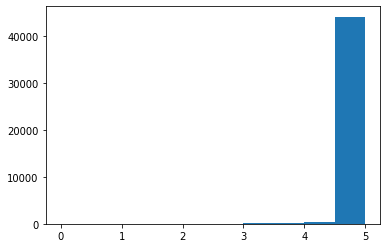

time: 259 ms (started: 2021-08-04 21:12:21 -06:00)


In [79]:
plt.hist(sc_rankings)

In [48]:
#algo = SVD()
#Load our best model. 
algo = SVD(n_factors = best_n_factors, n_epochs = best_n_epochs, lr_all = best_lr_all, reg_all = best_reg_all)
# algo = SVD(n_factors = 50, n_epochs = 10, lr_all = 0.005, reg_all = 0.04)
algo.fit(train_data)
test_prediction = algo.test(test_data)

#Create our final dev_evaluation_pool using our best algo for diversifitcation swapping. 
sorted_test_evaluation_pool = sort_evaluation_pools(algo, test_evaluation_pools, sc_rankings, ranking_movieID)

time: 26min 46s (started: 2021-08-04 19:39:28 -06:00)


#### 7.) Setup our diversification swapping. 

In [49]:
#Need to pass algo so that we can build the proper dictionary with predictions
topNPredicted_Split, nextNPredicted_Split, remainingNPredicted_Split = GetTopNSplitPools(sorted_test_evaluation_pool)

time: 6.91 s (started: 2021-08-04 20:06:21 -06:00)


#### 7.) Run our diversification swapping and plot tradeoff. 

In [ ]:
method, average_novelty, hit_rate, rmse, method_blended, average_novelty_blended, hit_rate_blended, rmse_blended, hit_rate_cutoff, hit_rate_cutoff_blended, swapping_iterations, swapping_iterations_blended = calcDiversityTradeoff(topNPredicted_Split, nextNPredicted_Split,remainingNPredicted_Split, test_df, test_prediction)

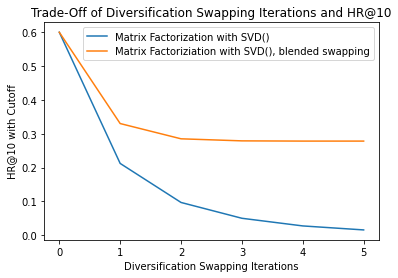

time: 174 ms (started: 2021-08-04 20:53:37 -06:00)


In [52]:
plt.rcParams.update({'font.size': 10})
plt.plot(swapping_iterations, hit_rate_cutoff, label = 'Matrix Factorization with SVD()')
plt.plot(swapping_iterations_blended, hit_rate_cutoff_blended, label = 'Matrix Factoriziation with SVD(), blended swapping')
plt.title("Trade-Off of Diversification Swapping Iterations and HR@10")
plt.xlabel("Diversification Swapping Iterations")
plt.ylabel("HR@10 with Cutoff")
plt.legend(loc = 'best')

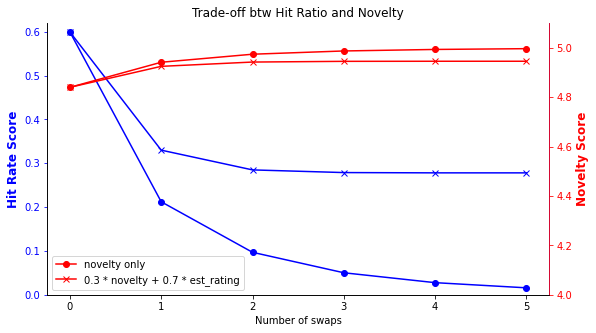

time: 186 ms (started: 2021-08-04 20:55:43 -06:00)


In [63]:
#Note we will use the non-blended version to tie to the methods used for Content Based, 
#despite better results. 

fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()
ax1.plot(swapping_iterations, hit_rate_cutoff, color='blue', marker='o', label='hit rate')
ax1.plot(swapping_iterations, hit_rate_cutoff_blended, color = 'blue', marker = 'x', label = 'hit rate blended')
ax2.plot(swapping_iterations, average_novelty, color='red', marker='o', label='novelty only')
ax2.plot(swapping_iterations, average_novelty_blended, color='red', marker='x', label='0.3 * novelty + 0.7 * est_rating')
ax1.set_title('Trade-off btw Hit Ratio and Novelty')
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.set_xlabel('Number of swaps')
ax1.set_ylabel('Hit Rate Score', fontsize='large', fontweight='bold')
ax1.spines['right'].set_color('blue')
ax1.yaxis.label.set_color('blue')
ax1.tick_params(axis='y', colors='blue')
ax1.set_ylim(0.0, 0.62)
ax2.set_ylim(4.0, 5.1)
ax1.set_xticks(swapping_iterations)
ax2.set_ylabel('Novelty Score', fontsize='large', fontweight='bold')
ax2.spines['right'].set_color('red')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
plt.legend(loc = 'lower left')
plt.show()